In [88]:
import httpx
import mlcroissant as mlc
import pandas as pd
import numpy as np
from matplotlib import pyplot as pyplot
import matplotlib.ticker as mticker
import seaborn as sns
import math

from pathlib import Path

In [13]:
# CONSTANTS
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = PARENT_FOLDER / "data"
DATASET_URL = (
    "https://www.kaggle.com/datasets/CooperUnion/cardataset/croissant/download"
)

In [ ]:
def download_data(url: str):
    dataset = mlc.Dataset(url)

    return dataset

car_dataset = download_data(DATASET_URL)
car_record_sets = car_dataset.metadata.record_sets
dataset_uuid = car_record_sets[0].uuid
car_records = car_dataset.records(dataset_uuid)



  -  [Metadata(Car Features and MSRP)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.


,data.csv/Year,data.csv/Engine+HP,data.csv/Engine+Cylinders,data.csv/Number+of+Doors,data.csv/highway+MPG,data.csv/city+mpg,data.csv/Popularity,data.csv/MSRP
count,11914.000000,11845.00000,11884.000000,11908.000000,11914.000000,11914.000000,11914.000000,1.191400e+04
mean,2010.384338,249.38607,5.628829,3.436093,26.637485,19.733255,1554.911197,4.059474e+04
std,7.579740,109.19187,1.780559,0.881315,8.863001,8.987798,1441.855347,6.010910e+04
min,1990.000000,55.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.100000e+04
50%,2015.000000,227.00000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.223125e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


In [35]:
df_car_raw = pd.DataFrame(car_records)
len(df_car_raw)

df_car = df_car_raw.copy(deep=True)

In [37]:
# Clean column names
df_car.columns = df_car.columns.str.lower().str.replace("+", "_").str.replace("data.csv/", "")
df_car.columns


Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

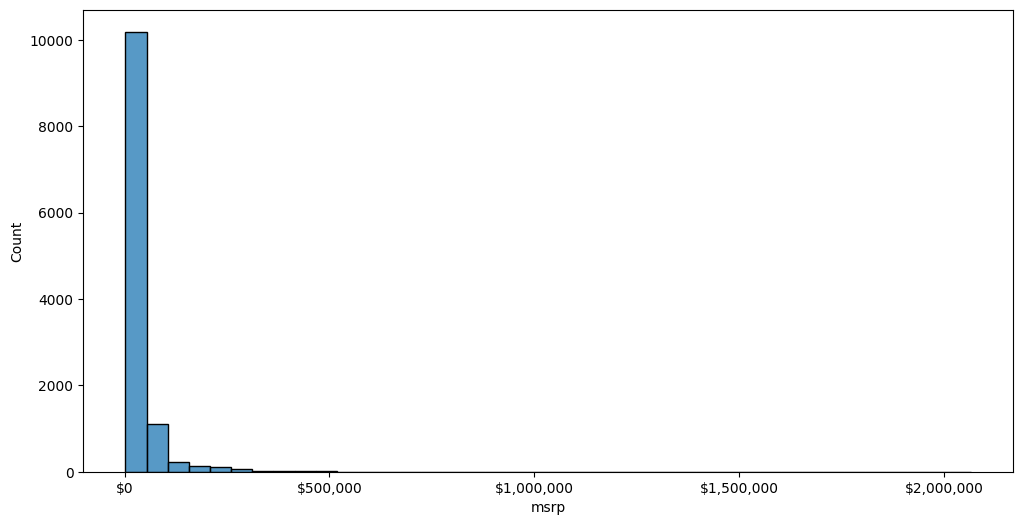

In [70]:
# plot the distribution of our target variable, the msrp

pyplot.rcParams["figure.figsize"] = (12, 6)

ax = sns.histplot(data=df_car, x="msrp", bins=40)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(x):,}'))

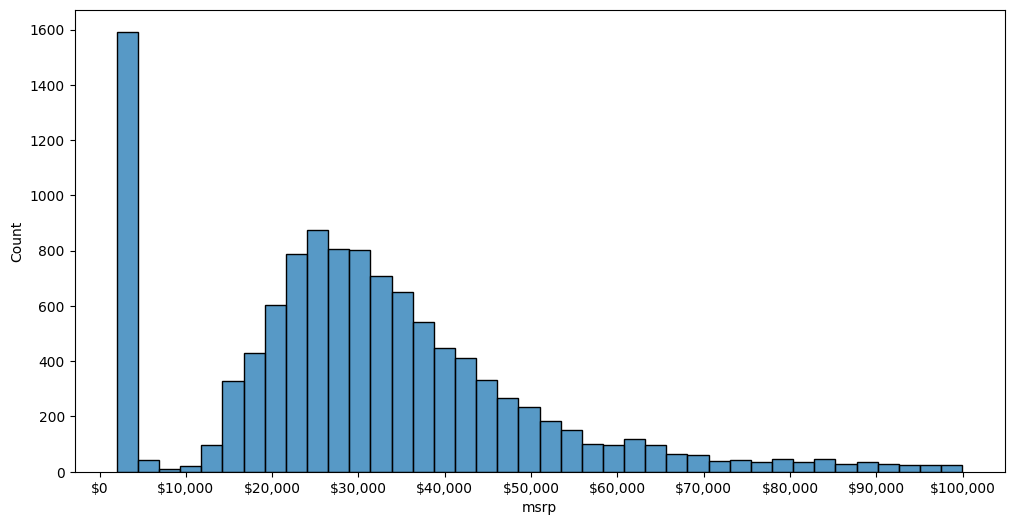

In [72]:
ax = sns.histplot(data=df_car[df_car["msrp"] < 100000], x="msrp", bins=40)
ax.xaxis.set_major_locator(mticker.MultipleLocator(10000))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${int(x):,}"))

In [89]:
df_car["msrp_normalized"] = df_car["msrp"].apply(
    lambda x: math.log(x + 1)
)

df_car["msrp_normalized_2"] = np.log1p(df_car.msrp)

df_car[["msrp", "msrp_normalized", "msrp_normalized_2"]]


,msrp,msrp_normalized,msrp_normalized_2
0,46135,10.739349,10.739349
1,40650,10.612779,10.612779
2,36350,10.500977,10.500977
3,29450,10.290483,10.290483
4,34500,10.448744,10.448744
...,...,...,...
11909,46120,10.739024,10.739024
11910,56670,10.945018,10.945018
11911,50620,10.832122,10.832122
11912,50920,10.838031,10.838031


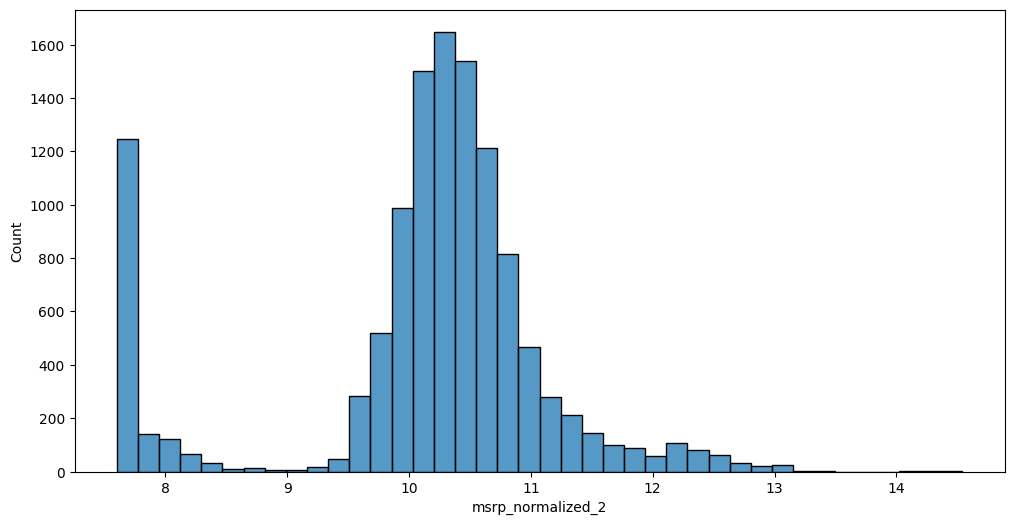

In [98]:
ax = sns.histplot(data=df_car, x="msrp_normalized_2", bins=40)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))